In [1]:
!wget -nc 140.114.76.113:8000/ccpd6000.zip
!unzip -nq ccpd6000.zip
!ls -alh

--2019-12-07 03:32:53--  http://140.114.76.113:8000/ccpd6000.zip
Connecting to 140.114.76.113:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332013713 (317M) [application/zip]
Saving to: ‘ccpd6000.zip’

ccpd6000.zip        100%[===================>] 316.63M  3.87MB/s    in 73s     

2019-12-07 03:34:07 (4.32 MB/s) - ‘ccpd6000.zip’ saved [332013713/332013713]

total 317M
drwxr-xr-x 1 root root 4.0K Dec  7 03:34 .
drwxr-xr-x 1 root root 4.0K Dec  7 03:31 ..
drwxr-xr-x 4 root root 4.0K Nov 19 11:35 ccpd6000
-rw-r--r-- 1 root root 317M Nov 19 11:44 ccpd6000.zip
drwxr-xr-x 1 root root 4.0K Dec  5 16:38 .config
drwxr-xr-x 1 root root 4.0K Nov 27 22:38 sample_data


In [2]:
!sha256sum ccpd6000.zip

977d7124a53e565c3f2b371a871ee04ebbe572f07deb0b38c5548ddaae0cb2c9  ccpd6000.zip


In [0]:
import random
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython import display

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import functional as tf
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset

# Fix the seed for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Some constants
FIELDS = ['BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y'] # the fields in csv
IMG_SIZE = (192, 320) # the input image size (width, height) of the model
ROOT_DIR = Path('./ccpd6000/') # the root directory of the dataset

In [0]:
def draw_kpts(img, kpts, c='red', r=2.0):
    '''
    Draw `kpts` on `img`. `img` is modified inplace.
    Args:
        img: (PIL.Image) the image to be drawn
        kpts: (torch.tensor) the normalized positions (x, y) of keypoints, shaped [4, 2]
        c: (str) color
        r: (float) radius of the drawn circle
    Return:
        img: (PIL.Image) the result.
    '''
    draw = ImageDraw.Draw(img)
    size = torch.tensor([img.size]).float()
    kpts = kpts.view(4, 2) * size
    kpts = kpts.numpy().tolist()
    for x, y in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img

3000
torch.Size([3, 320, 192])
tensor(1.)
torch.Size([8])


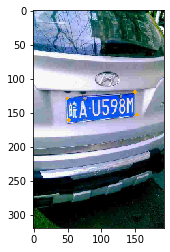

In [5]:
class TrainData(Dataset):
    def __init__(self, csv_path, img_dir):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records') # List of Dict
        self.img_dir = Path(img_dir)

    def __len__(self):
        '''Return the number of sample
        '''
        self.img_paths = self.img_dir.glob('*.jpg')
        self.img_paths = sorted(list(self.img_paths))
        return len(self.img_paths)

    def __getitem__(self, idx):
        '''Map index `idx` to a sample, i.e., an image and its keypoints

        Args:
            idx: (int) index
        Return:
            img: (torch.FloatTensor) values in 0 ~ 1 and shaped [3, H, W]
            kpt: (torch.FloatTensor) normalized positions of 
                bottom-right, bottom-left, top-left, top-right corners. 
                For example, position (256, 256) of an (512, 512) image should be (0.5, 0.5)
                `kpt` should have same order as `FIELDS` and is shaped [8].
        '''

        img_path = self.img_paths[idx]
        
        # load image
        img = Image.open(img_path)
        W, H = img.size
        img = img.convert('RGB')
        img = img.resize((192, 320))
        img = tf.to_tensor(img)
        
        # parse annotation
        kpt = [self.anns[idx]['BR_x'], self.anns[idx]['BR_y'], self.anns[idx]['BL_x'], self.anns[idx]['BL_y'],
               self.anns[idx]['TL_x'], self.anns[idx]['TL_y'], self.anns[idx]['TR_x'], self.anns[idx]['TR_y']]
        kpt = torch.tensor(kpt)
        kpt = kpt.view(4, 2)
        kpt = kpt / torch.FloatTensor([W, H])
        kpt = kpt.view(-1)
        
        return img, kpt


# Do some checking and visualization
data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
print(len(data))    # should be 3000

img, kpt = data[-1] # get a sample
print(img.size())   # should be [3, H, W]
print(img.max())    # should be <= 1.0
print(kpt.size())   # should be [8]

img = tf.to_pil_image(img) # convert tensor of shape (3, H, W) to PIL.Image
vis = draw_kpts(img, kpt, c='orange')
plt.imshow(vis)
plt.show()

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__() # necessary
        self.conv = nn.Conv2d(cin, cout, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(cout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Net(nn.Module):
    def __init__(self):
        '''Defines parameters (what layers you gonna use)
        '''
        super().__init__() # necessary
        self.features = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((4, 4)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
        )
        self.regression = nn.Sequential(
            nn.Flatten(), nn.Linear(480, 32), nn.ReLU(), nn.Linear(32, 8), nn.Sigmoid()
        )

    def forward(self, img_b):
        '''Define how layers are interact, that is, the forward function.
        In this network, img_b is passed to self.features and 
        the result is passed to self.regression.

        Args:
            img_b: (torch.FloatTensor) input images (mini-batch), shaped [N, 3, H, W]
        Return:
            kpt_b: (torch.FloatTensor) the predictions (mini-batch), shaped [N, 8]
        '''
        N = img_b.size(0)
        img_b = self.features(img_b)
        img_b = img_b.view(N, -1)
        kpt_b = self.regression(img_b)
        return kpt_b


# Do some checking
loader = DataLoader(data, batch_size=10) # dataloader constructs mini-batch from a dataset
img_b, kpt_b = next(iter(loader)) # get an mini-batch
print(img_b.size()) # expects [N, 3, H, W]
print(kpt_b.size()) # expects [N, 8]

# Do a forwarding
device = 'cuda'     # the computing device, 'cuda' or 'cpu'
model = Net().to(device) # instantiate network and move it to device
criterion = nn.L1Loss()  # the criterion (loss function)

img_b = img_b.to(device)
kpt_b = kpt_b.to(device)
pred_b = model(img_b)
loss = criterion(pred_b, kpt_b)
print(loss)

torch.Size([10, 3, 320, 192])
torch.Size([10, 8])
tensor(0.1244, device='cuda:0', grad_fn=<L1LossBackward>)


Epoch 000:
train loss: 0.029297777777537705
valid loss: 0.020340335136279464
Epoch 001:
train loss: 0.01790705631719902
valid loss: 0.016538959338019292
Epoch 002:
train loss: 0.013780434156069532
valid loss: 0.013070115462566416
Epoch 003:
train loss: 0.012482772197108716
valid loss: 0.01096390700743844
Epoch 004:
train loss: 0.011715393387324488
valid loss: 0.01090964797573785
Epoch 005:
train loss: 0.01110257870168425
valid loss: 0.011054498508262138
Epoch 006:
train loss: 0.010296053216249372
valid loss: 0.011677053136130175
Epoch 007:
train loss: 0.009923322879088422
valid loss: 0.009699378395453095
Epoch 008:
train loss: 0.009809028607560322
valid loss: 0.011267446260899306
Epoch 009:
train loss: 0.009532326378393918
valid loss: 0.010909213948373993
Epoch 010:
train loss: 0.007233954273397103
valid loss: 0.008020992095892628
Epoch 011:
train loss: 0.006686083107100179
valid loss: 0.007900298899039626
Epoch 012:
train loss: 0.006498593178306086
valid loss: 0.007897470433575412
Epo

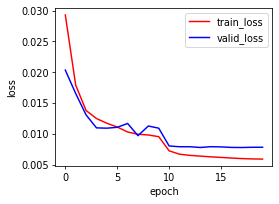

In [7]:
class Trainer:
    def __init__(self, log_dir):
        '''Initialize the varibles for training
        Args:
            log_dir: (pathlib.Path) the direction used for logging
        '''
        self.log_dir = log_dir

        # Datasets and dataloaders
        # 1. Split the whole training data into train and valid (validation)
        # 2. Construct visualization data (25 training samples, 25 validation samples)
        # 3. Make the corresponding dataloaders
        data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
        pivot = len(data) * 4 // 5
        self.train_set = Subset(data, range(0, pivot))
        self.valid_set = Subset(data, range(pivot, len(data)))
        self.visul_set = ConcatDataset(
            [
                Subset(self.train_set, random.sample(range(len(self.train_set)), k=25)),
                Subset(self.valid_set, random.sample(range(len(self.valid_set)), k=25)),
            ]
        )
        self.train_loader = DataLoader(self.train_set, 10, shuffle=True, num_workers=4)
        self.valid_loader = DataLoader(self.valid_set, 10, shuffle=False, num_workers=4)
        self.visul_loader = DataLoader(self.visul_set, 10, shuffle=False)

        # model, loss function, optimizer
        self.device = 'cuda'
        self.model = Net().to(self.device)
        self.criterion = nn.L1Loss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 10, gamma=0.1, last_epoch=-1)
        self.max_epoch = 20

    def run(self):
        metrics = {'train_loss': [], 'valid_loss': []}
        best_loss = 99

        for self.epoch in range(self.max_epoch):
            train_loss = self.train() # train 1 epoch
            self.scheduler.step()
            valid_loss = self.valid() # valid 1 epoch
            self.visul()              # visualization

            print(f'Epoch {self.epoch:03d}:')
            print('train loss:', train_loss)
            print('valid loss:', valid_loss)
            metrics['train_loss'].append(train_loss)
            metrics['valid_loss'].append(valid_loss)

            # Save the parameters(weights) of the model to disk
            if valid_loss < best_loss:
                best_loss = valid_loss
                torch.save(self.model.state_dict(), 'net_params.pkl')

        # Plot the loss curve against epoch
        plt.figure(figsize=(4, 3), dpi=70)
        plt.plot(range(len(metrics['train_loss'])), metrics['train_loss'], color='red', label='train_loss')
        plt.plot(range(len(metrics['valid_loss'])), metrics['valid_loss'], color='blue', label='valid_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(loc='upper right')
        plt.show()

    def train(self):
        '''Train one epoch
        1. Switch model to training mode
        2. Iterate mini-batches and do:
            a. clear gradient
            b. forward to get loss
            c. loss backward
            d. update parameters
        3. Return the average loss in this epoch
        '''
        model.train()
        loss_steps = []

        for img_b, kpt_b in iter(self.train_loader):
            img_b = img_b.to(self.device)
            kpt_b = kpt_b.to(self.device)

            self.optimizer.zero_grad()
            pred_b = self.model(img_b)
            loss = self.criterion(pred_b, kpt_b)
            loss.backward()
            self.optimizer.step()

            loss = loss.detach().item()
            loss_steps.append(loss)

        avg_loss = sum(loss_steps) / len(loss_steps)
        
        return avg_loss

    @torch.no_grad()
    def valid(self):
        '''Validate one epoch
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do forwarding to get loss
        3. Return average loss in this epoch
        '''
        model.eval()
        loss_steps = []

        with torch.no_grad():
          for img_b, kpt_b in iter(self.valid_loader):
              img_b = img_b.to(device)
              kpt_b = kpt_b.to(device)

              pred_b = self.model(img_b)
              loss = self.criterion(pred_b, kpt_b)

              loss = loss.detach().item()
              loss_steps.append(loss)

        avg_loss = sum(loss_steps) / len(loss_steps)
        
        return avg_loss

    @torch.no_grad()
    def visul(self):
        ''' Visualize some samples
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do:
            a. forward to get predictions
            b. visualize and save visualization to log_dir / f'{epoch:03d}'
        As a result, first 25 samples are from training data and last 25 samples are from validation.
        '''
        self.model.eval()
        epoch_dir = self.log_dir / f'{self.epoch:03d}'
        epoch_dir.mkdir(parents=True)
        idx = 0
        for img_b, kpt_b in iter(self.visul_loader):
            pred_b = self.model(img_b.to(self.device)).to('cpu')
            for img, kpt, pred in zip(img_b, kpt_b, pred_b):
                img = tf.to_pil_image(img)
                vis = draw_kpts(img, kpt, c='orange')
                vis = draw_kpts(img, pred, c='red')
                vis.save(epoch_dir / f'{idx:03d}.jpg')
                idx += 1


log_dir = Path('./runs/') / f'{datetime.now():%b.%d %H:%M:%S}'
log_dir.mkdir(parents=True)
Trainer(log_dir).run()

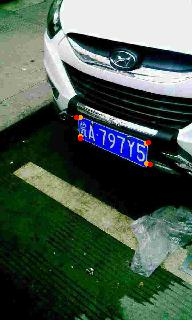

In [8]:
display.Image(str(log_dir / '019' / '000.jpg'))

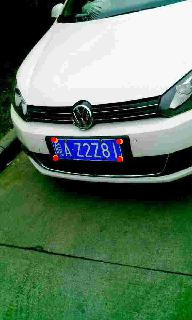

In [9]:
display.Image(str(log_dir / '019' / '025.jpg'))

In [10]:
# Do testing
class CCPDTest:
    def __init__(self, img_dir, img_size):
        img_paths = Path(img_dir).glob('*.jpg')
        self.img_paths = sorted(list(img_paths))
        self.img_size = img_size

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = img.resize(self.img_size)
        img = tf.to_tensor(img)
        return img


test_set = CCPDTest('./ccpd6000/test_images/', (192, 320))
test_loader = DataLoader(test_set, 32, shuffle=False, num_workers=2)

device = 'cuda'
model = Net().to(device)
model.load_state_dict(torch.load('./net_params.pkl'))
model.eval()

log_dir = Path('./test_images/') / f'{datetime.now():%Y.%m.%d-%H:%M:%S}'
log_dir.mkdir(parents=True)

def test(self):
    anns = []
    for img_b in iter(test_loader):
        kpt_b = model(img_b.to(device)).cpu()

        for img, kpt in zip(img_b, kpt_b):
            img = tf.to_pil_image(img)
            size = torch.tensor([720, 1160]).float()
            kpt = kpt.view(4, 2)
            kpt = kpt * size
            kpt = kpt.view(-1)
            anns.append([f'{self.n:04d}.jpg', *kpt.numpy().tolist()])
            self.update()

    return pd.DataFrame(anns)

from tqdm import tqdm
with torch.no_grad():
    with tqdm(total=len(test_set)) as pbar:
        df_pred = test(pbar)
    print(df_pred)
    df_pred.columns = ['name', 'BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y']
    df_pred.to_csv('test.csv', float_format='%.5f', index=False)

100%|██████████| 3000/3000 [00:30<00:00, 98.15it/s] 


             0           1           2  ...           6           7           8
0     0000.jpg  369.956451  603.322998  ...  507.650940  361.244507  551.327881
1     0001.jpg  443.629272  536.695496  ...  485.808716  440.159668  488.001312
2     0002.jpg  460.642365  504.749512  ...  467.316406  460.944824  464.984100
3     0003.jpg  496.596100  602.071838  ...  516.066833  491.815735  542.425842
4     0004.jpg  440.024323  587.622925  ...  525.232910  436.277039  515.889771
...        ...         ...         ...  ...         ...         ...         ...
2995  2995.jpg  446.345581  640.991211  ...  572.951782  443.514191  585.101318
2996  2996.jpg  502.987793  634.540710  ...  572.002075  502.321106  575.868713
2997  2997.jpg  315.794678  388.333923  ...  342.052521  318.685852  342.679108
2998  2998.jpg  444.919128  563.454651  ...  477.861969  436.135468  488.306244
2999  2999.jpg  504.921936  654.292908  ...  527.784973  496.564148  586.455994

[3000 rows x 9 columns]


In [11]:
!curl -F "file=@test.csv" -X POST 140.114.76.113:5000/cs6550 -i

HTTP/1.1 100 Continue

HTTP/1.0 200 OK
Content-Type: application/json
Content-Length: 16
Server: Werkzeug/0.16.0 Python/3.7.5
Date: Sat, 07 Dec 2019 03:44:58 GMT

{"rmse":13.342}
